# **Install API**

In [2]:
!pip -q install  fredapi


# **Import Library**

In [4]:

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pandas_datareader.data import DataReader
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
import statsmodels.api as sm
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

# **Pull Data from API**

In [6]:

# ================================================================
# 1. Pull monthly macro-economic series from FRED
# ================================================================
start_date = "1970-01-01"
end_date   = datetime.today().strftime("%Y-%m-%d")

series_codes = {
    "CPIAUCSL": "CPI",       # Consumer Price Index (all items)
    "PPIACO"  : "PPI",       # Producer Price Index (all commodities)
    "UNRATE"  : "UnempRate", # Unemployment rate
}

raw_dfs = []
for code, new_name in series_codes.items():
    s = DataReader(code, data_source="fred", start=start_date, end=end_date)
    s.columns = [new_name]
    raw_dfs.append(s)

df = pd.concat(raw_dfs, axis=1)

In [7]:
df

,CPI,PPI,UnempRate
DATE,,,
1970-01-01,37.900,36.500,3.9
1970-02-01,38.100,36.700,4.2
1970-03-01,38.300,36.700,4.4
1970-04-01,38.500,36.800,4.6
1970-05-01,38.600,36.800,4.8
...,...,...,...
2025-04-01,320.321,258.392,4.2
2025-05-01,320.580,258.642,4.2
2025-06-01,321.500,260.690,4.1


## **Set the date column**

In [9]:
# Ensure a proper DateTimeIndex at monthly frequency
df.index = pd.to_datetime(df.index)
df = df.resample("ME").last()   # keep last value in each month

print("Raw shape (after merge & resample):", df.shape)
df.head()

Raw shape (after merge & resample): (668, 3)


,CPI,PPI,UnempRate
DATE,,,
1970-01-31,37.9,36.5,3.9
1970-02-28,38.1,36.7,4.2
1970-03-31,38.3,36.7,4.4
1970-04-30,38.5,36.8,4.6
1970-05-31,38.6,36.8,4.8


In [10]:


# ================================================================
# 2. Feature Engineering & Target Labelling
# ================================================================
# Year-over-year inflation rate (%)
df["InflationRate"] = df["CPI"].pct_change(12) * 100

# Additional explanatory features
df["CPI_yoy"] = df["CPI"].pct_change(12) * 100
df["PPI_yoy"] = df["PPI"].pct_change(12) * 100
df["UnempRate_change"] = df["UnempRate"].diff()


# **Target categorisation**

In [12]:

# Drop rows with any NaNs (first 12 months, etc.)
df.dropna(inplace=True)
print("Shape after feature engineering & NA drop:", df.shape)

# Target categorisation
def classify_inflation(rate):
    if rate < 2:
        return "Low"
    elif rate < 5:
        return "Moderate"
    else:
        return "High"

df["InflationCategory"] = df["InflationRate"].apply(classify_inflation)

Shape after feature engineering & NA drop: (656, 7)


In [13]:
# Re-order columns for readability
cols = ["InflationRate", "InflationCategory",
        "CPI", "CPI_yoy", "PPI", "PPI_yoy",
        "UnempRate", "UnempRate_change"]
df = df[cols]

In [14]:
df

,InflationRate,InflationCategory,CPI,CPI_yoy,PPI,PPI_yoy,UnempRate,UnempRate_change
DATE,,,,,,,,
1971-01-31,5.277045,High,39.900,5.277045,37.300,2.191781,5.9,-0.2
1971-02-28,4.724409,Moderate,39.900,4.724409,37.700,2.724796,5.9,0.0
1971-03-31,4.438642,Moderate,40.000,4.438642,37.800,2.997275,6.0,0.1
1971-04-30,4.155844,Moderate,40.100,4.155844,37.900,2.989130,5.9,-0.1
1971-05-31,4.404145,Moderate,40.300,4.404145,38.100,3.532609,5.9,0.0
...,...,...,...,...,...,...,...,...
2025-04-30,2.333747,Moderate,320.321,2.333747,258.392,0.550242,4.2,0.0
2025-05-31,2.375934,Moderate,320.580,2.375934,258.642,1.303890,4.2,0.0
2025-06-30,2.672683,Moderate,321.500,2.672683,260.690,1.866252,4.1,-0.1


# **Data Summary**

In [16]:
print("\n=== Info ===")
df.info()


=== Info ===
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 656 entries, 1971-01-31 to 2025-08-31
Freq: ME
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   InflationRate      656 non-null    float64
 1   InflationCategory  656 non-null    object 
 2   CPI                656 non-null    float64
 3   CPI_yoy            656 non-null    float64
 4   PPI                656 non-null    float64
 5   PPI_yoy            656 non-null    float64
 6   UnempRate          656 non-null    float64
 7   UnempRate_change   656 non-null    float64
dtypes: float64(7), object(1)
memory usage: 46.1+ KB


In [17]:

print("\n=== Descriptive Statistics ===")
display(df.describe().T)



=== Descriptive Statistics ===


,count,mean,std,min,25%,50%,75%,max
InflationRate,656.0,3.968335,2.914625,-1.958761,2.129363,3.136193,4.812267,14.592275
CPI,656.0,164.501723,75.527247,39.900000,104.625000,162.400000,227.377750,323.364000
CPI_yoy,656.0,3.968335,2.914625,-1.958761,2.129363,3.136193,4.812267,14.592275
PPI,656.0,139.473459,58.007444,37.300000,101.600000,127.250000,189.950000,280.251000
PPI_yoy,656.0,3.793525,6.094562,-16.058394,0.322455,3.258035,6.303762,23.440860
UnempRate,656.0,6.086128,1.721975,3.400000,4.800000,5.800000,7.200000,14.800000
UnempRate_change,656.0,-0.002744,0.463829,-2.200000,-0.100000,0.000000,0.100000,10.400000


In [18]:


print("\nClass counts:")
print(df["InflationCategory"].value_counts())


Class counts:
InflationCategory
Moderate    359
High        153
Low         144
Name: count, dtype: int64


## **Exploratory Data Analysis**

##  **Time-series plots**

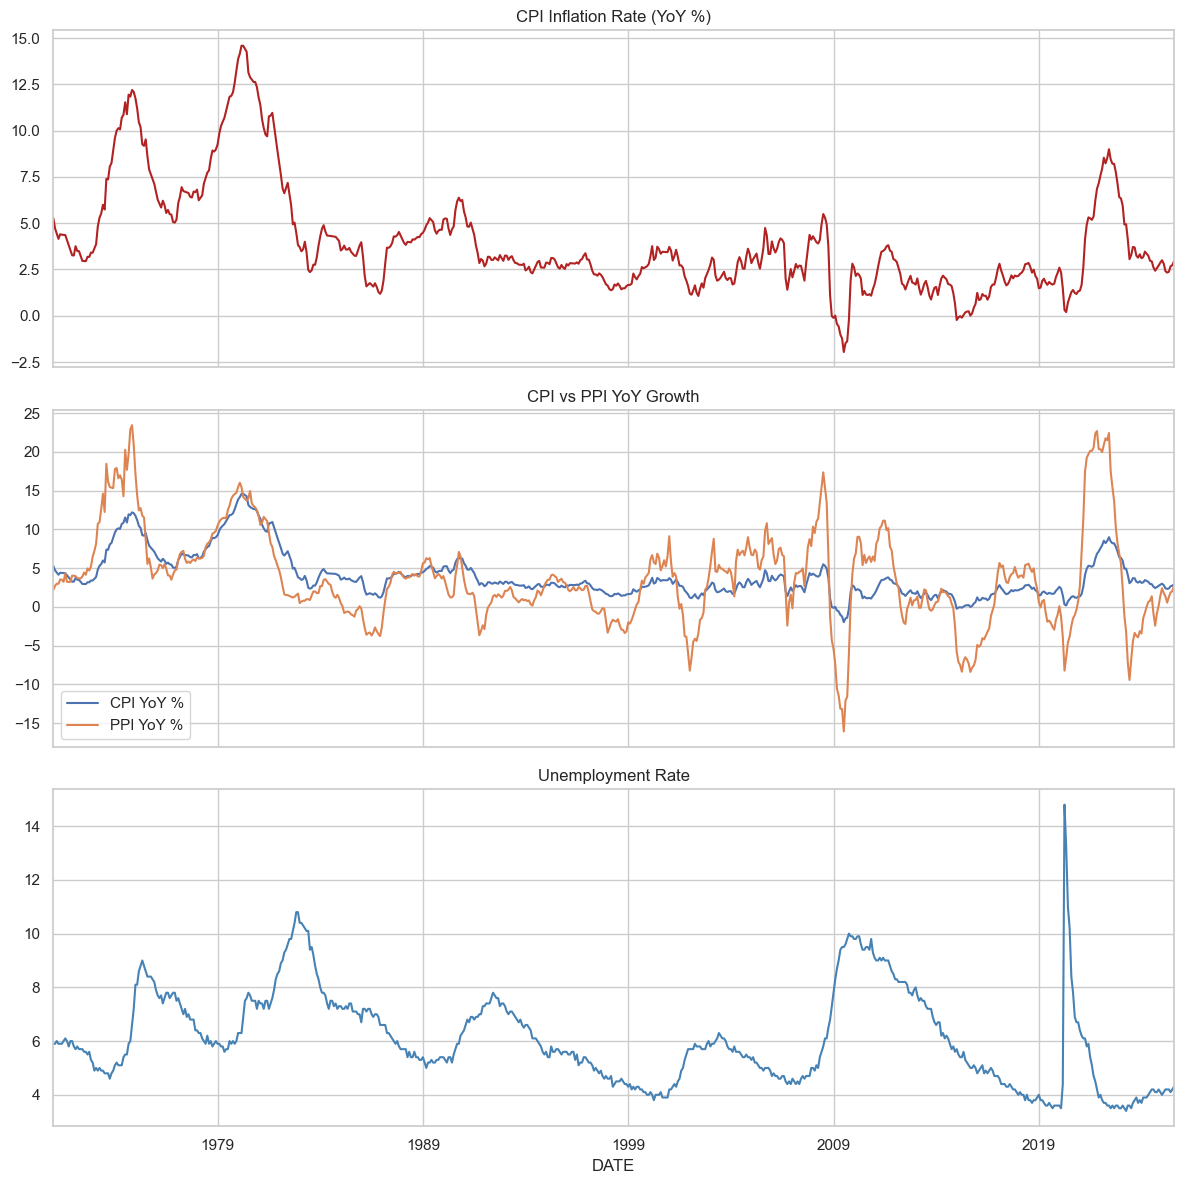

In [21]:

## 4-A Time-series plots
fig, ax = plt.subplots(3, 1, figsize=(12, 12), sharex=True)
df["InflationRate"].plot(ax=ax[0], color="firebrick")
ax[0].set_title("CPI Inflation Rate (YoY %)")

df["CPI_yoy"].plot(ax=ax[1], label="CPI YoY %")
df["PPI_yoy"].plot(ax=ax[1], label="PPI YoY %")
ax[1].set_title("CPI vs PPI YoY Growth")
ax[1].legend()

df["UnempRate"].plot(ax=ax[2], color="steelblue")
ax[2].set_title("Unemployment Rate")
plt.tight_layout()
plt.show()

##  **Inflation-category distribution**

C:\Users\DELL\AppData\Local\Temp\ipykernel_37244\673517962.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x="InflationCategory",


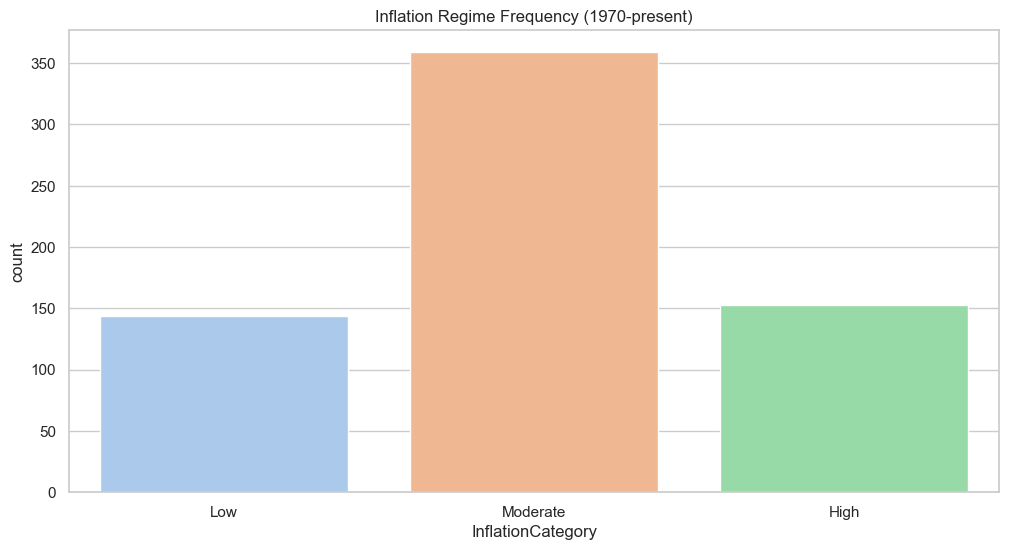

In [23]:


##  Inflation-category distribution
sns.countplot(data=df, x="InflationCategory",
              order=["Low", "Moderate", "High"],
              palette="pastel")
plt.title("Inflation Regime Frequency (1970-present)")
plt.show()

# **Correlation heat map**

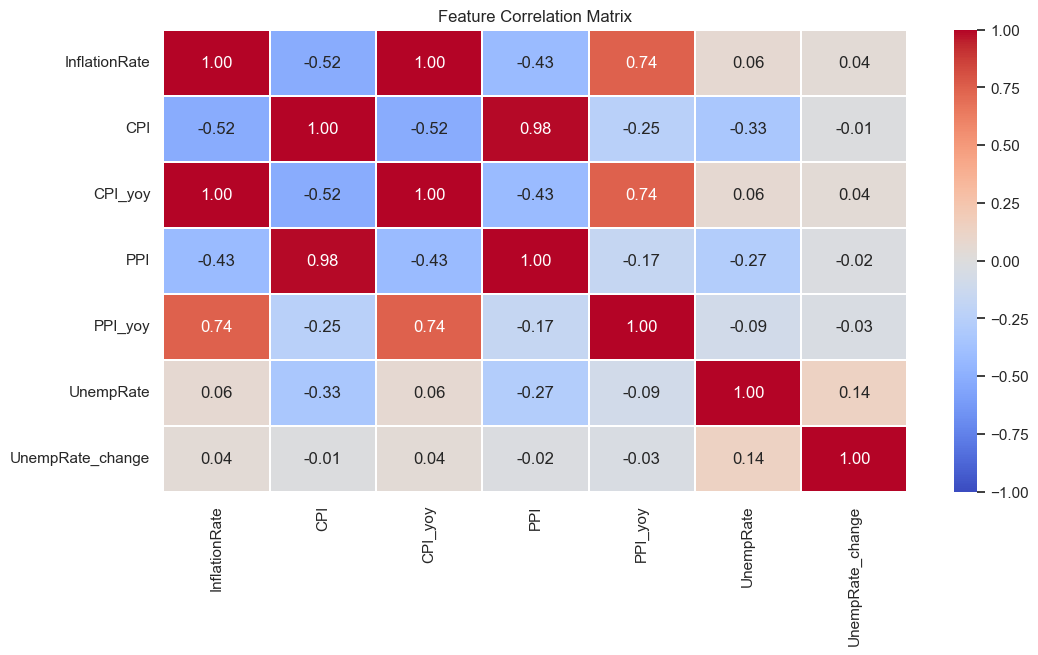

In [25]:


##  Correlation heat map
corr_mat = df.drop(columns="InflationCategory").corr()
sns.heatmap(corr_mat, annot=True, cmap="coolwarm", fmt=".2f",
            vmin=-1, vmax=1, linewidths=0.3)
plt.title("Feature Correlation Matrix")
plt.show()

## **Pairplot coloured by inflation regime**

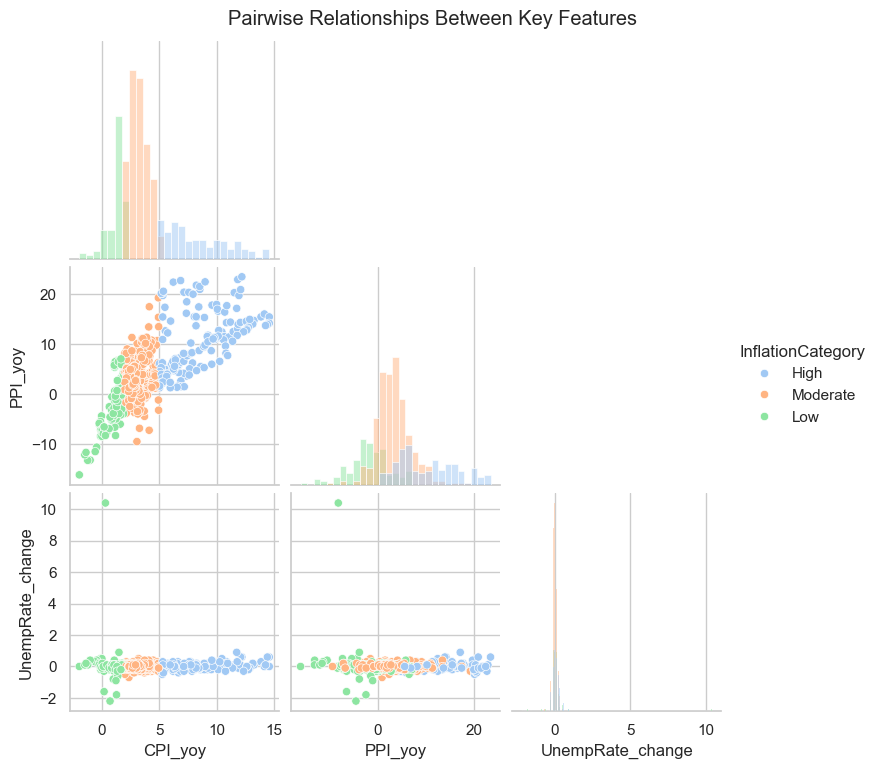

In [27]:

## Pairplot coloured by inflation regime
sns.pairplot(df[["CPI_yoy", "PPI_yoy", "UnempRate_change",
                 "InflationCategory"]],
             hue="InflationCategory", palette="pastel",
             corner=True, diag_kind="hist")
plt.suptitle("Pairwise Relationships Between Key Features", y=1.02)
plt.show()


## **Data Preparation for ML**

In [29]:
features = ["CPI_yoy", "PPI_yoy", "UnempRate_change",
            "CPI", "PPI", "UnempRate"]
X = df[features]
y = df["InflationCategory"]

le = LabelEncoder()
y_enc = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(
    X, y_enc, test_size=0.25, stratify=y_enc, random_state=42
)

scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s  = scaler.transform(X_test)

print("Train shape:", X_train_s.shape, "  Test shape:", X_test_s.shape)


Train shape: (492, 6)   Test shape: (164, 6)


## **Model Training & Evaluation**

In [31]:
models = {
    "SVM"              : SVC(kernel='rbf', probability=True, random_state=42),
    "Neural Network"   : MLPClassifier(hidden_layer_sizes=(64,32),
                                       max_iter=500, early_stopping=True,
                                       random_state=42),
    "Random Forest"    : RandomForestClassifier(n_estimators=100, random_state=42),

    "LogisticRegression": LogisticRegression(multi_class='ovr', solver='liblinear',
                                             random_state=42)
}

results = {}
for name, mdl in models.items():
    mdl.fit(X_train_s, y_train)
    y_pred = mdl.predict(X_test_s)

    results[name] = {
        "Accuracy" : accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred, average='weighted'),
        "Recall"   : recall_score(y_test, y_pred, average='weighted'),
        "F1"       : f1_score(y_test, y_pred, average='weighted'),
        "CM"       : confusion_matrix(y_test, y_pred),
        "Report"   : classification_report(y_test, y_pred,
                                           target_names=le.classes_)
    }

pd.DataFrame(results).T[["Accuracy","Precision","Recall","F1"]]

,Accuracy,Precision,Recall,F1
SVM,0.884146,0.892993,0.884146,0.881902
Neural Network,0.792683,0.833406,0.792683,0.776253
Random Forest,1.0,1.0,1.0,1.0
LogisticRegression,0.884146,0.895554,0.884146,0.880439


##**Confusion Matrices & Performance Plots**

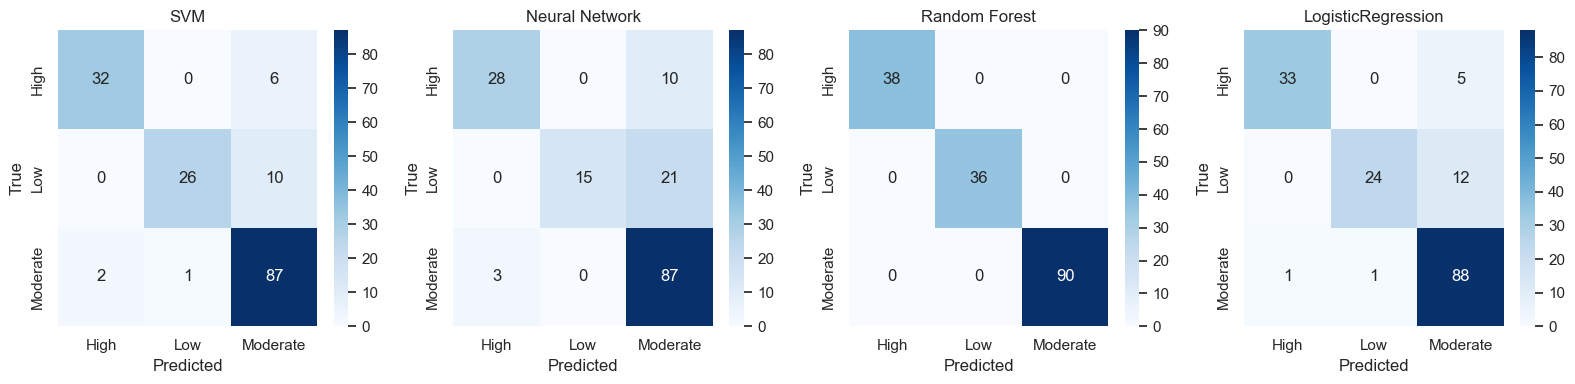

In [33]:
fig, axes = plt.subplots(1, len(models), figsize=(4*len(models), 4), squeeze=False)
axes = axes.ravel()

for ax, (name, res) in zip(axes, results.items()):
    sns.heatmap(res["CM"], annot=True, fmt="d", cmap="Blues",
                xticklabels=le.classes_, yticklabels=le.classes_, ax=ax)
    ax.set_title(name); ax.set_xlabel("Predicted"); ax.set_ylabel("True")

plt.tight_layout(); plt.show()

# **5-Fold Stratified Cross-Validation**

In [35]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = {}

X_all_s = scaler.fit_transform(X)  # scale once for full set
for name, mdl in models.items():
    acc, f1 = [], []
    for train_idx, test_idx in kf.split(X_all_s, y_enc):
        X_tr, X_te = X_all_s[train_idx], X_all_s[test_idx]
        y_tr, y_te = y_enc[train_idx], y_enc[test_idx]

        m = mdl.__class__(**mdl.get_params())   # fresh clone
        m.fit(X_tr, y_tr)
        y_pr = m.predict(X_te)

        acc.append(accuracy_score(y_te, y_pr))
        f1.append(f1_score(y_te, y_pr, average='weighted'))

    cv_scores[name] = {"Acc CV mean": np.mean(acc), "Acc CV std": np.std(acc),
                       "F1 CV mean": np.mean(f1),  "F1 CV std": np.std(f1)}

pd.DataFrame(cv_scores).T

,Acc CV mean,Acc CV std,F1 CV mean,F1 CV std
SVM,0.925330,0.016865,0.924769,0.017003
Neural Network,0.835369,0.024874,0.826411,0.033943
Random Forest,0.998473,0.003053,0.998480,0.003040
LogisticRegression,0.910062,0.015558,0.906798,0.016288


# **t-tests**

In [37]:
# ================================================
#  Cell 7 – 5-Fold Stratified Cross-Validation
#         (stores per-fold scores for t-tests)
# ================================================
from collections import defaultdict

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
X_all_s = scaler.fit_transform(X)          # scale once on full data
y_all   = le.transform(y)

cv_raw   = defaultdict(lambda: {"Acc": [], "F1": []})   # per-fold lists
cv_stats = {}                                           # mean / std table

for name, mdl in models.items():
    for train_idx, test_idx in kf.split(X_all_s, y_all):
        X_tr, X_te = X_all_s[train_idx], X_all_s[test_idx]
        y_tr, y_te = y_all[train_idx],   y_all[test_idx]

        m = mdl.__class__(**mdl.get_params())           # clone
        m.fit(X_tr, y_tr)
        y_pr = m.predict(X_te)

        cv_raw[name]["Acc"].append(accuracy_score(y_te, y_pr))
        cv_raw[name]["F1" ].append(f1_score(y_te, y_pr, average='weighted'))

    cv_stats[name] = {
        "Acc μ": np.mean(cv_raw[name]["Acc"]),
        "Acc σ": np.std(cv_raw[name]["Acc"]),
        "F1 μ" : np.mean(cv_raw[name]["F1"]),
        "F1 σ" : np.std(cv_raw[name]["F1"]),
    }

pd.DataFrame(cv_stats).T


,Acc μ,Acc σ,F1 μ,F1 σ
SVM,0.925330,0.016865,0.924769,0.017003
Neural Network,0.835369,0.024874,0.826411,0.033943
Random Forest,0.998473,0.003053,0.998480,0.003040
LogisticRegression,0.910062,0.015558,0.906798,0.016288


In [38]:
# ================================================
#  Paired t-test and Wilcoxon signed-rank test
# ================================================
from scipy.stats import ttest_rel, wilcoxon

# Pick Random Forest as baseline
baseline = "Random Forest"

# Loop through other models and compare against RF
for name in models.keys():
    if name == baseline:
        continue  # skip comparing RF with itself

    # Get per-fold F1 scores
    rf_scores  = cv_raw[baseline]["F1"]
    mdl_scores = cv_raw[name]["F1"]

    # Paired t-test
    t_stat, p_val = ttest_rel(rf_scores, mdl_scores)

    # Wilcoxon signed-rank test (non-parametric)
    try:
        w_stat, w_p_val = wilcoxon(rf_scores, mdl_scores)
    except ValueError:
        w_stat, w_p_val = (None, None)  # in case of all equal values

    print(f"\n🔹 {baseline} vs {name}")
    print(f"  Paired t-test: t = {t_stat:.4f}, p = {p_val:.4f}")
    print(f"  Wilcoxon test: W = {w_stat}, p = {w_p_val}")



🔹 Random Forest vs SVM
  Paired t-test: t = 8.0055, p = 0.0013
  Wilcoxon test: W = 0.0, p = 0.0625

🔹 Random Forest vs Neural Network
  Paired t-test: t = 10.9927, p = 0.0004
  Wilcoxon test: W = 0.0, p = 0.0625

🔹 Random Forest vs LogisticRegression
  Paired t-test: t = 11.1841, p = 0.0004
  Wilcoxon test: W = 0.0, p = 0.0625
